In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
import functools
import itertools
from jax import numpy as jnp
import jax
import equinox as eqx
import distrax


@functools.partial(jax.jit, static_argnames=["num_bits"])
def num_to_binarray(num, num_bits):
    return jnp.array(jax.vmap(lambda i: num >> i & 1)(jnp.arange(num_bits)), dtype=jnp.int32)

class GridEnv(eqx.Module):
    state: jnp.ndarray
    r0: float = eqx.static_field()
    r1: float = eqx.static_field()
    r2: float = eqx.static_field()
    horizon: int = eqx.static_field()
    ndim: int = eqx.static_field()
    action_space: distrax.Categorical = eqx.static_field()

    def __init__(self, horizon, r0, r1, r2, ndim=2):
        self.state: jnp.ndarray = jnp.zeros(ndim, dtype=jnp.int32)
        self.ndim = ndim
        self.r0 = r0
        self.r1 = r1
        self.r2 = r2
        self.horizon = horizon
        self.action_space = distrax.Categorical(probs=jnp.ones(ndim + 1))

    @eqx.filter_jit
    def state_to_onehot(self, state):
        '''
        Converts a environment state to a one-hot encoded observation, for use with neural networks.
        '''
        observation = jnp.zeros((self.ndim*self.horizon,), dtype=jnp.float32)
        observation = observation.at[jnp.arange(self.ndim) * self.horizon + state].set(1)
        return observation

    @eqx.filter_jit
    def reward(self, state) -> jnp.ndarray:
        # normalize state
        tmp = jnp.abs(state/(self.horizon - 1) - 0.5) 
        indicator_r1 = jnp.prod(tmp > 0.25)
        indicator_r2 = jnp.prod((tmp > 0.3) *  (tmp < 0.4))
        r = self.r0 + self.r1 * indicator_r1 + self.r2 * indicator_r2
        return r

    @eqx.filter_jit
    def get_all_state_rewards(self):
        states = jnp.array(list(itertools.product(list(range(self.horizon)), repeat=self.ndim)))
        valids = jax.vmap(self.state_valid)(states)
        return {
            "states": states,
            "valids": valids,
            "rewards": jax.vmap(self.reward)(states) * valids
        }

    @eqx.filter_jit
    def state_valid(self, state):
        '''
        Checks if a state is in the observation space.
        '''
        return jnp.all(state >= 0) * jnp.all(state < self.horizon) *  (jnp.sum(state >= self.horizon - 1) <= 1)

    @eqx.filter_jit
    def step(grid, action):
        grid = jax.lax.cond(action < grid.state.shape[0], 
            lambda _: eqx.tree_at(
                lambda grid: grid.state, grid, grid.state.at[action].add(1)
            ), lambda _: grid, None)
        reward = grid.reward(grid.state)
        stop_step = action == grid.state.shape[0]
        horizon_finished = jnp.max(grid.state) >= grid.horizon - 1


        done = jax.lax.cond(horizon_finished, lambda _: True,  lambda _: stop_step, None)
        return (
            grid,
            reward,
            done 
        )

    @eqx.filter_jit
    def reset(self):
        grid = eqx.tree_at(
            lambda grid: grid.state, self, jnp.zeros_like(self.state)
        )
        return grid 

    @eqx.filter_jit
    def inverse_transitions(self, state):
        '''
        Returns a list of all possible state + /actions that can transition to the given state. 
        Each element of the resulting PyTree also has a valid boolean, indicating if the state/action is valid.
        '''
        def get_index_parent(idx: int):
            tmp = state.at[idx].add(-1)
            pred = self.state_valid(tmp)
            return {"states":tmp, "valid":pred, "actions":idx}
        return jax.vmap(get_index_parent)(jnp.arange(state.shape[0])) 

    
    @eqx.filter_jit
    def transitions(self, state):
        def get_index_child(idx: int):
            tmp = state.at[idx].add(1)
            pred = self.state_valid(tmp)
            return {"states":tmp, "valid":pred, "actions":idx}
        return jax.vmap(get_index_child)(jnp.arange(state.shape[0])) 



env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [2]:
from src.gflownet import FlowNetwork

env = GridEnv(8, 0.1, 0.5, 2.0, 4)
all_state_rewards = env.get_all_state_rewards()
key = jax.random.PRNGKey(0)
agent = FlowNetwork(
    env.state_to_onehot(env.state).shape[0],
    [256, 256],
    env.action_space.logits.shape[0],
    key,
)


[ 562  567  602  607  877  882  917  922 3012 3017 3052 3057 3327 3332
 3367 3372]
[[1 1 1 1]
 [1 1 1 6]
 [1 1 6 1]
 [1 1 6 6]
 [1 6 1 1]
 [1 6 1 6]
 [1 6 6 1]
 [1 6 6 6]
 [6 1 1 1]
 [6 1 1 6]
 [6 1 6 1]
 [6 1 6 6]
 [6 6 1 1]
 [6 6 1 6]
 [6 6 6 1]
 [6 6 6 6]]
Counter({0.10000000149011612: 3584, 0.6000000238418579: 173, 2.5999999046325684: 16})


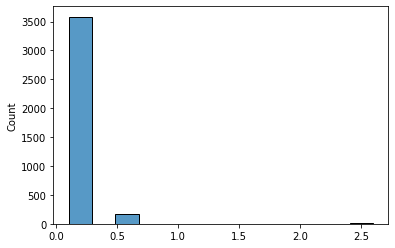

In [3]:
from collections import Counter


rewards = all_state_rewards["rewards"][all_state_rewards["valids"] == 1]
valid_states = all_state_rewards["states"][all_state_rewards["valids"] == 1]

best_reward = jnp.max(rewards)
reward_modes = jnp.argwhere(rewards == best_reward).flatten()
print(reward_modes)
print(valid_states[reward_modes])

import seaborn as sns

sns.histplot(rewards)

rc = (Counter([r.item() for r in rewards]))



In [4]:
from typing import Dict


@eqx.filter_jit
def policy_trajectory(
    agent: FlowNetwork,
    env: GridEnv,
    steps_per_episode: int,
    key: jax.random.KeyArray,
) -> Dict[str, jnp.ndarray]:
    """
    Collects steps_per_episode steps from the environment using the agent's policy. Note that there may be multiple terminal states in the trajectory.
    """

    def loop(loopstate, _):
        key = jax.random.split(loopstate[0], 2)[1]
        env = loopstate[1]

        state = env.state
        encoded_state = env.state_to_onehot(state)
        transitions = env.transitions(env.state)
        flows = agent(encoded_state)
        flows = flows * jnp.concatenate([transitions["valid"], jnp.array([True])])
        action = distrax.Categorical(logits=flows).sample(seed=key)
        env, reward, done = env.step(action)
        env = jax.lax.cond(done, lambda _: env.reset(), lambda _: env, None)
        reward = jax.lax.cond(done, lambda _: reward, lambda _: 0.0, None)

        return (
            (key, env),
            {
                "states": state,
                "actions": action,
                "rewards": reward,
                "dones": done,
            },
        )

    (key, env), trajectory = jax.lax.scan(
        loop, (key, env), jnp.arange(steps_per_episode)
    )

    # mask out the last episode if it is not done
    def mask_dones(is_done, curr_done):
        is_done = jax.lax.cond(curr_done, lambda _: True, lambda _: is_done, None)
        return (is_done, jax.lax.cond(is_done, lambda _: 1.0, lambda _: 0.0, None))

    dones_mask = jax.lax.scan(mask_dones, False, trajectory["dones"], reverse=True)[1]

    return trajectory


In [5]:
import optax

optimizer = optax.adam(1e-3)
optimizer_state = optimizer.init(eqx.filter(agent, eqx.filters.is_array))


In [28]:
from src.gflownet import flow_matching_loss
from tqdm import trange

@eqx.filter_jit
def train_flownet(agent, key, env:GridEnv, optimizer_state):
    trajectories = jax.vmap(functools.partial(policy_trajectory, agent, env, env.ndim * env.horizon))(
        jax.random.split(key, 16)
    )

    def loss_grad(trajectory):
        loss, gradients = eqx.filter_value_and_grad(flow_matching_loss)(
            agent,
            trajectory["states"],
            trajectory["rewards"],
            trajectory["dones"],
            env.transitions,
            env.inverse_transitions,
            env.state_to_onehot,
        )
        return {"loss": loss, "gradients": gradients}

    loss_grads = jax.vmap(loss_grad)(trajectories)
    gradients_avg = jax.tree_util.tree_map(
        lambda x: jnp.mean(x, axis=0), loss_grads["gradients"]
    )
    updates, optimizer_state = optimizer.update(gradients_avg, optimizer_state, agent)
    agent = eqx.apply_updates(agent, updates)
    return loss_grads["loss"].mean(), agent, env, optimizer_state


losses = []
keys = jax.random.split(key, 10000)
for i in (t := trange(10000)):
    loss, agent, env, optimizer_state = train_flownet(
        agent, keys[i], env, optimizer_state
    )
    t.set_description(f"Loss: {loss}")
    losses.append(loss.item())


Loss: 1.0879134606511798e-06: 100%|██████████| 10000/10000 [01:19<00:00, 125.28it/s]


(10000, 32, 4)
Counter({0.6000000238418579: 9011, 0.10000000149011612: 527, 2.5999999046325684: 462})
404


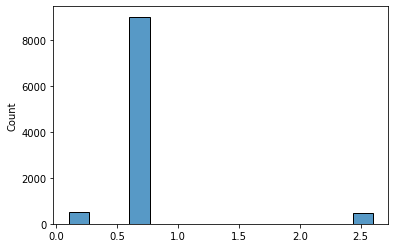

In [29]:
import numpy

keys = jax.random.split(key, 10000)
rewards = []
trajectories = jax.vmap(functools.partial(policy_trajectory, agent, env, env.ndim*env.horizon))(keys)
rewards = jnp.max(trajectories["rewards"], axis=-1)
rewards_bestidx = jnp.argmax(trajectories["rewards"], axis=-1)
final_reward_action = jnp.take_along_axis(
    trajectories["actions"], rewards_bestidx[..., None], axis=-1
)

print(trajectories["states"].shape)
best_states = jax.vmap(lambda s, i: s[i])(trajectories["states"], rewards_bestidx)

import seaborn as sns

sns.histplot(rewards)
print(Counter([r.item() for r in rewards]))

Counter([tuple(numpy.array(s).tolist()) for s in best_states])
